In [1]:
from model import *
import numpy as np
from utils import *
import os, sys
from blendshapes import load_blendshape, BasicBlendshapes
# plot the results
import matplotlib.pyplot as plt
import igl
import tqdm

## Helper functions

In [2]:
def manifold_projection(model, weights, blendshapes: BasicBlendshapes):
    proj_weights = model.infer(weights)
    if type(proj_weights) is torch.Tensor:
        proj_weights = proj_weights.detach().numpy()
    if len(weights.shape) == 1:
        V_proj = blendshapes.eval(proj_weights)
    else:
        # save the original shape
        original_shape = proj_weights.shape
        # reshape to 2D
        proj_weights = proj_weights.reshape(-1, proj_weights.shape[-1])   
        V_proj = np.zeros((proj_weights.shape[0], blendshapes.V.shape[0], 3))
        for i in range(proj_weights.shape[0]):
            V_proj[i] = blendshapes.eval(proj_weights[i])
        # reshape back to original shape, it could either be 3d or 4d
        try:
            V_proj = V_proj.reshape(original_shape[0], -1, 3)
        except:
            V_proj = V_proj.reshape(original_shape[0], original_shape[1], -1, 3)
        proj_weights = proj_weights.reshape(original_shape)
    return proj_weights, V_proj


## Naive Baselines

In [3]:
from regex import W


class NaiveLocal:
    def __init__(self, dim):
        self.weight = np.zeros(dim)
    def infer(self, x):
        return x
    
class Closest_K_Infer:
    def __init__(self, model, k=5):
        self.model = model
        self.k = k
    def infer(self, x):
        raw_output = self.model.infer(x)
        raw_output = raw_output.detach().numpy()
        x = x.detach().numpy()
        delta = raw_output - x
        # top k mask
        if len(x.shape) == 2:
            for i in range(x.shape[0]):
                mask = np.ones(len(raw_output[i]))
                mask[np.argsort(raw_output[i])[-self.k:]] = 0
                raw_output[i] = mask * delta[i] + x[i]
        elif len(x.shape) == 1:
            mask = np.ones(len(raw_output))
            mask[np.argsort(raw_output)[-self.k:]] = 0
            raw_output = mask * delta + x
        return raw_output

## Inputs

In [4]:
# input paths
EXPERIMENT_PATH = "../experiments"
PROJ_ROOT = "../"

# models to compare
experiment_names = ["lipmlp"]
# experiment_names = os.listdir(EXPERIMENT_PATH)

################## For evaluating denoising performance ##################
# numbers of random frames to sample from the dataset
n_frames = 1000
# levels of noise
noise_levels = np.arange(0, 1, 0.1)

# other paths
BLENDSHAPES_PATH = os.path.join(PROJ_ROOT, "data", "AppleAR", "OBJs")
BLENDSHAPES_PATH = os.path.join(PROJ_ROOT, "data", "SP", "OBJs")

## Step 1: Evaluate model on de-noising reconstruction

### load models

In [5]:

models_dict = {}
for ii in range(len(experiment_names)):
    if experiment_names[ii][0] == ".":
        continue
    experiment_folder_path = os.path.join(EXPERIMENT_PATH, experiment_names[ii])
    config_path = os.path.join(experiment_folder_path, "config.json")
    config = json.load(open(config_path))
    
    # get type fo model
    try:
        model_type = config["network"]["type"]
        
    except:
        continue
    
    # load model
    try:
        model = load_model(config)
        models_dict[model_type] = model
        models_dict[model_type + "_ver_K"] = Closest_K_Infer(model)
    except:
        print("failed at {}".format(model_type))
        continue
models_dict["no projection"] = NaiveLocal(50)

/Users/evanpan/Documents/GitHub/ManifoldExploration/experiments/lipmlp/model.pt


### Load data and blendshapes

In [6]:
blendshapes = load_blendshape("SP")
dataset = load_dataset(dataset="SP")
weights_gt = random_sample(dataset, n_frames)

SP dataset size: 4225


### Metric 1 - reconstruction accuracy - evaluate the denoising capability of different models

In [63]:
from os import error
from librosa import ex
from numpy import dtype
from torch import mode


n_trials = 20
# noise levels
sv_samples = np.linspace(0, 1, n_trials)

# store error
noise_level_dict = {}
# store the error with respect to the ground truth
error_dict = {}

for model_name in models_dict:
    model = models_dict[model_name]
    for i in range(n_trials):
        sv = sv_samples[i] # different noise levels
        weights = weights_gt + np.random.normal(loc=0, scale=sv, size=weights_gt.shape)
        weights = np.clip(weights, 0, 1)
        weights = torch.from_numpy(weights).type(torch.FloatTensor)
        # weights and vertex positions
        proj_weights_dm, V_proj_dm = manifold_projection(model, weights, blendshapes)
        try:
            noise_level_dict[model_name].append(np.linalg.norm(weights - weights_gt))
            error_dict[model_name].append(np.linalg.norm(proj_weights_dm - weights_gt))
        except:
            noise_level_dict[model_name] = [np.linalg.norm(weights - weights_gt)]
            error_dict[model_name] = [np.linalg.norm(proj_weights_dm - weights_gt)]

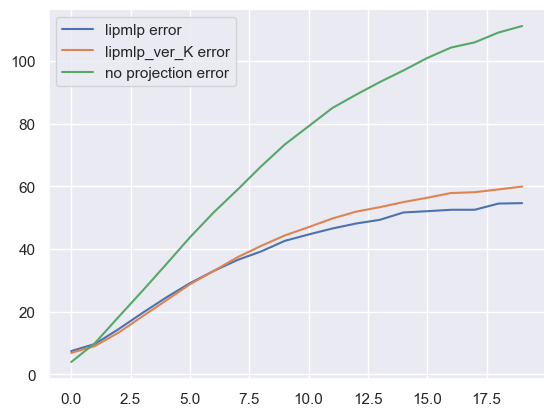

In [64]:
# plt.figure()
for model_name in models_dict:
    plt.plot(error_dict[model_name], label=model_name + " error")
# plt.plot(noise_level_dict["naive"], label="noise level")
plt.legend()
plt.show()

### Metric 1.5 Threshold of perceivable movements

In [7]:
"""
TODO:Need to compute an appropriate threshold when computing activation:

I would assume a weight change of 0.1 would be perceivable on the mesh. 
So for each blendshape, I will move weight by that amount, and observe 
the mean vertex movement magnitude of the moved vertex, this will be a 
condidate for the "threshold of movement" of that vertex. I will then 
compute such threshold candidates for all interval of weight movements 
(i.e. 0-0.1, 0.1-0.2, 0.2-0.3, etc.), as well as all blendweight changes
(i.e. jaw and pucker blendweight change will both affect the same vertex
on the lip). To compute the final threshold of movement of each vertex, I 
will average over all the candidates.
""";

threshold_of_activation = 0

### Metric 2 - Slider responsiveness - Locality

In [82]:
def compute_locality_error(unaltered_mesh, modified_weight, projected_modified_weight, blendshapes, threshold=0):
    # compute the mesh vertices of the user's originally intended manipulation
    intended_mesh = blendshapes.eval(modified_weight)
    projected_mesh = blendshapes.eval(projected_modified_weight)
    # compute the IOU of moved vertices
    dv_intended_mesh = np.linalg.norm(intended_mesh - unaltered_mesh, axis=-1)
    dv_projected_mesh = np.linalg.norm(projected_mesh - unaltered_mesh, axis=-1)

    # compute vertex activation
    intended_mesh_activation = np.where(dv_intended_mesh > threshold, 1, 0)
    projected_mesh_activation = np.where(dv_projected_mesh > threshold, 1, 0)
    
    # compute the intersection
    intersection = np.logical_and(intended_mesh_activation, projected_mesh_activation)
    union = np.logical_or(intended_mesh_activation, projected_mesh_activation)
    if union.sum() == 0:
        return 0
    return np.sum(intersection) / np.sum(union)

In [87]:
# make 100 changes per face from the dataset (roughly 3 minutes per n_trials = 100, n_frames = 1000)
n_trials = 10
# change a single variable and see if it can be 
locality_error_dict = {}
for model_name in models_dict:
    model = models_dict[model_name]
    weights = weights_gt.copy()
    # add a new dimension
    weights = np.expand_dims(weights, axis=0)
    weights = np.repeat(weights, n_trials, axis=0)
    
    # generate n_trials where a single weight parameter is changed
    changed_mask = np.zeros(weights.shape, dtype=bool)
    # choose the weight index to change
    for i in range(n_trials): # per trial
        for j in range(0, weights.shape[1]): # per frame in dataset
            index = np.random.randint(0, weights.shape[2])
            changed_mask[i, j, index] = 1 
    
    # determine how much to change the weight by, sampling from normal distribution
    weight_delta = np.random.normal(loc=0, scale=0.5, size=[weights.shape[0] * weights.shape[1]])
    # make sure abs(weight_delta) > 0.1 so it's kind of significant
    weight_delta = np.sign(weight_delta) * np.maximum(np.abs(weight_delta), 0.1)
    modified_weights = weights.copy()
    modified_weights[changed_mask] += weight_delta
    random_offsets = np.random.normal(loc=0.3, scale=0.1, size=modified_weights.shape)
    modified_weights = np.where(modified_weights > 1, 1 - random_offsets, modified_weights)
    modified_weights = np.where(modified_weights < 0, random_offsets, modified_weights)
    
    # iterate through the trials/frames to compute the error
    for j in range(weights.shape[1]):
        # compute the mesh for the unalterned weights
        unaltered_mesh = blendshapes.eval(weights_gt[j])
        for i in range(n_trials):
            # get the modified weight as a torch tensor
            # compute proejcted weight
            proj_weights_dm, V_proj_dm = manifold_projection(model, torch.from_numpy(modified_weights[i, j]).type(torch.FloatTensor), blendshapes)
            # compute locality error
            locality_error = compute_locality_error(unaltered_mesh, modified_weights[i, j], proj_weights_dm, blendshapes, threshold=threshold_of_activation)
            try:
                locality_error_dict[model_name].append(locality_error)
            except:
                locality_error_dict[model_name] = [locality_error]

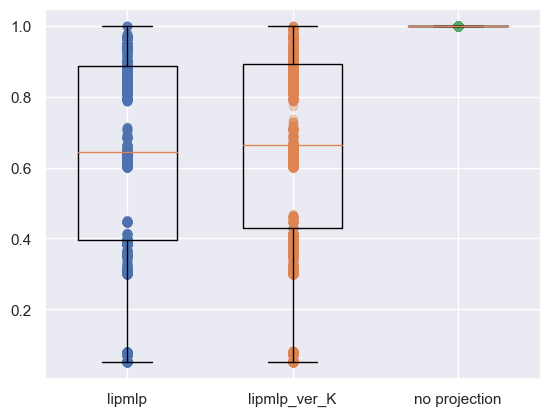

In [88]:
i = 0
model_names = list(locality_error_dict.keys())
for model in model_names:
    # plot mean and std with a box plot
    plt.boxplot(locality_error_dict[model], positions=[i], widths=0.6)
    # plot the scatter plot
    plt.scatter([i] * len(locality_error_dict[model]), locality_error_dict[model], alpha=0.3)
    # label each box graph on the x axis
    i += 1
plt.xticks(range(len(model_names)), model_names)
plt.show()

### Metric 2 - Slider responsiveness - Non-antagonistic

In [37]:
def simpliest_neighbourhood(V, F):
    out_indices = []
    for i in range(0, V.shape[0]):
        out_indices.append([i])
    return out_indices


def topological_distance_queries(V, F, query_indices, n_rings):
    # V is unused as F encodes all related topological info
    # n_rings is the number of rings to search for
    import igl
    adj = igl.adjacency_list(F)
    reached = []
    for i in range(len(query_indices)):
        q_reached = []
        q = query_indices[i]
        current_ring = 0
        Q = [q]
        # BFS for N-rings
        while current_ring < n_rings:
            next_ring = []
            for v in Q:
                next_ring.extend(adj[v])
            Q = next_ring
            q_reached.extend(Q)
            current_ring += 1
        reached.append(q_reached)
    return reached
def geodesic_distance_queries(V, F, query_indices, cutoff):
    # cutoff is the maximum distance to search for
    geodesic = igl.heat_geodesic(V, F, query_indices, 1000)
    reached = []
    for i in range(len(query_indices)):
        reached.extend(np.where(geodesic[i] < cutoff))
    return reached

def topological_distance_neighbourhood(V, F, cut_off_rings=3):
    return topological_distance_queries(V, F, list(range(0, V.shape[0])), cut_off_rings)
# vertex_neighbourhood = simpliest_neighbourhood(blendshapes.V, blendshapes.F)

vertex_neighbourhood = topological_distance_neighbourhood(blendshapes.V, blendshapes.F, 3)


In [92]:
def compute_antagonistic_error_ver1(unaltered_mesh, intended_mesh, projected_mesh, vertex_neighbourhood, threshold=0):
    # compute vertex_changes
    dv_intended_mesh = intended_mesh - unaltered_mesh
    dv_projected_mesh = projected_mesh - unaltered_mesh
    
    moved_indices = np.where(np.linalg.norm(dv_intended_mesh, axis=-1) > 0, 1, 0)
    # compute mean vertex movement direction within the neighbourhood
    mean_neighbourhood_movement_projected = np.zeros(unaltered_mesh.shape)
    for i in range(0, len(vertex_neighbourhood)):
        if moved_indices[i] == 0:
            continue
        mean_neighbourhood_movement_projected[i] = np.mean(dv_projected_mesh[vertex_neighbourhood[i]], axis=0)
    moved_indices = moved_indices.astype(bool)
    # compute the angle between the mean movement and the intended movement of each vertex if there is a movement, 
        
    # use the mask to get the subset of the df_intended_mesh
    subset_dv_intended_mesh = dv_intended_mesh[moved_indices]
    subset_dv_intended_mesh = subset_dv_intended_mesh / np.linalg.norm(subset_dv_intended_mesh, axis=-1)[:, np.newaxis]
    # plt.plot(subset_dv_intended_mesh)
    # plt.show()
    # these are the moved vertices around the intended vertex by the projection
    subset_mean_neighbourhood_movement_projected = mean_neighbourhood_movement_projected[moved_indices]
    projected_norm_displacement_norm = np.linalg.norm(subset_mean_neighbourhood_movement_projected, axis=-1)[:, np.newaxis]
    subset_mean_neighbourhood_movement_projected = subset_mean_neighbourhood_movement_projected / projected_norm_displacement_norm
    # compute the alignment (cos theta between two vertex displacements)
    alignment = np.sum(subset_dv_intended_mesh * subset_mean_neighbourhood_movement_projected, axis=-1)
    alignment = np.where(projected_norm_displacement_norm == 0, 0, alignment)
    average_alignment = np.mean(alignment)
    # print(average_alignment, subset_dv_intended_mesh.mean())
    return average_alignment

In [97]:
# make 100 changes per face from the dataset (roughly 50 minutes per n_trials = 10, n_frames = 1000...... can be more efficient)
n_trials = 10
# change a single variable and see if it can be 
non_antagonistic_error_dict = {}
for model_name in models_dict:
    model = models_dict[model_name]
    weights = weights_gt.copy()
    # add a new dimension
    weights = np.expand_dims(weights, axis=0)
    weights = np.repeat(weights, n_trials, axis=0)
    
    # generate n_trials where a single weight parameter is changed
    changed_mask = np.zeros(weights.shape, dtype=bool)
    # choose the weight index to change
    for i in range(n_trials): # per trial
        for j in range(0, weights.shape[1]): # per frame in dataset
            index = np.random.randint(0, weights.shape[2])
            changed_mask[i, j, index] = 1 
    
    # determine how much to change the weight by, sampling from normal distribution
    weight_delta = np.random.normal(loc=0, scale=0.5, size=[weights.shape[0] * weights.shape[1]])
    # make sure abs(weight_delta) > 0.1 so it's kind of significant
    weight_delta = np.sign(weight_delta) * np.maximum(np.abs(weight_delta), 0.1)
    modified_weights = weights.copy()
    modified_weights[changed_mask] += weight_delta

    # make sure the weights are all changed by a bit
    modified_weights[changed_mask] = np.where(weights[changed_mask] == modified_weights[changed_mask], weights[changed_mask] - weight_delta, modified_weights[changed_mask])

    # do a second pass
    random_offsets = np.random.normal(loc=0.3, scale=0.1, size=modified_weights.shape)
    modified_weights = np.where(modified_weights > 1, 1 - random_offsets, modified_weights)
    modified_weights = np.where(modified_weights < 0, random_offsets, modified_weights)

    # iterate through the trials/frames to compute the error
    for j in range(weights.shape[1]):
    # for j in range(20):
        # compute the mesh for the unalterned weights
        unaltered_mesh = blendshapes.eval(weights_gt[j])
        for i in range(n_trials):
            # get the modified weight as a torch tensor
            # compute proejcted weight
            proj_weights_dm, V_proj_dm = manifold_projection(model, torch.from_numpy(modified_weights[i, j]).type(torch.FloatTensor), blendshapes)
            # compute antagonistic error
            intended_mesh = blendshapes.eval(modified_weights[i, j])
            projected_mesg = V_proj_dm
            # compute antagonistic error
            non_antagonistic_error = compute_antagonistic_error_ver1(unaltered_mesh, intended_mesh, projected_mesg, vertex_neighbourhood, threshold=threshold_of_activation)
            try:
                non_antagonistic_error_dict[model_name].append(non_antagonistic_error)
            except:
                non_antagonistic_error_dict[model_name] = [non_antagonistic_error]

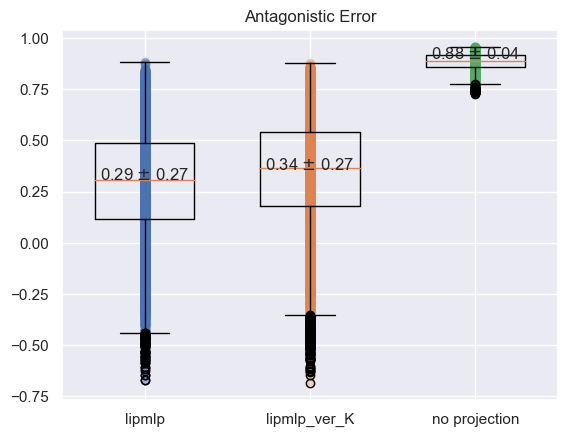

In [99]:
i = 0
model_names = list(non_antagonistic_error_dict.keys())
for model in model_names:
    # plot mean and std with a box plot
    plt.boxplot(non_antagonistic_error_dict[model], positions=[i], widths=0.6)
    # plot the scatter plot
    plt.scatter([i] * len(non_antagonistic_error_dict[model]), non_antagonistic_error_dict[model], alpha=0.3)
    # label each box with a mean and std
    plt.text(i, np.mean(non_antagonistic_error_dict[model]), "{:.2f} $\pm$ {:.2f}".format(np.mean(non_antagonistic_error_dict[model]), np.std(non_antagonistic_error_dict[model])), ha='center', va='bottom')
    i += 1
plt.title("Antagonistic Error")
plt.xticks(range(len(model_names)), model_names)
plt.show()

### Metric 3: Usefulness - Coarse to Fine Prediction

In [141]:
# Define the threshold of coarse movement
coarsely_activated_threshold = 0.3


# change a single variable and see if it can be 
error_in_coarse_blendweights_dict = {}
error_in_fine_blendweights_dict = {}

for model_name in models_dict:
    model = models_dict[model_name]
    weights = weights_gt.copy()
    # modified the weight to only keep the coarse activated weights (i.e. the weights the animator would tend to activate first as they are the most perceivable/noticeable)
    coarse_weights = np.where(weights > coarsely_activated_threshold, weights, 0)
    coarse_weight_mask = np.where(coarse_weights > 0, True, False)
    fine_weight_mask = np.where(coarse_weights == 0, True, False)

    # compute the projected weights
    proj_weights, __ = manifold_projection(model, torch.from_numpy(coarse_weights).type(torch.FloatTensor), blendshapes)

    for i in range(0, fine_weight_mask.shape[0]):
        # compute errors in the fine blendweights (using infinity norm because in general most weights are not activated, so I'm just gonna try and get an upper-bound)
        fine_weights_error = np.max(np.abs(proj_weights[i, fine_weight_mask[i]] - weights[i, fine_weight_mask[i]]), axis=-1)
        # compute errors in the coarse blendweights
        coarse_weights_error = np.max(np.abs(proj_weights[i, fine_weight_mask[i]] - weights[i, fine_weight_mask[i]]), axis=-1)
        # store
        try:
            error_in_coarse_blendweights_dict[model_name].append(coarse_weights_error)
            error_in_fine_blendweights_dict[model_name].append(fine_weights_error)
        except:
            error_in_coarse_blendweights_dict[model_name] = [coarse_weights_error]
            error_in_fine_blendweights_dict[model_name] = [fine_weights_error]

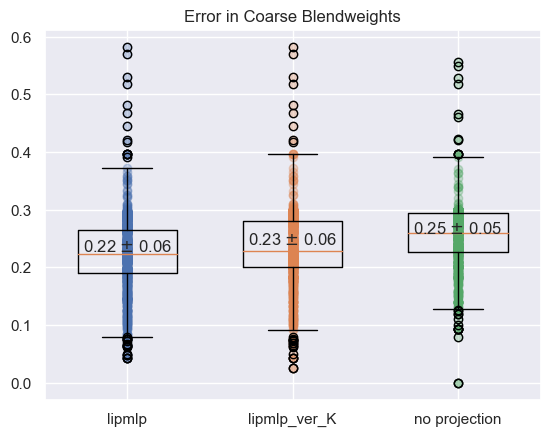

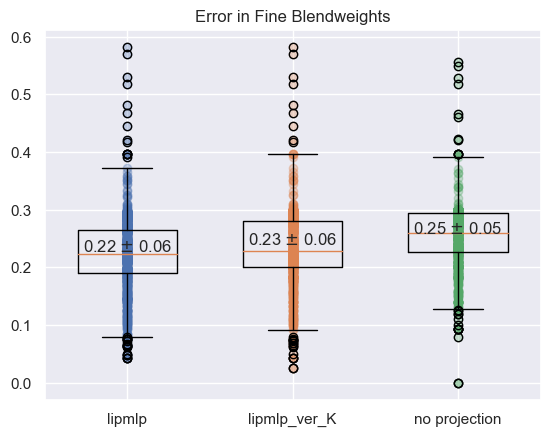

In [142]:
model_names = list(non_antagonistic_error_dict.keys())
i = 0
for model in model_names:
    # plot mean and std with a box plot
    plt.boxplot(error_in_coarse_blendweights_dict[model], positions=[i], widths=0.6)
    # plot the scatter plot
    plt.scatter([i] * len(error_in_coarse_blendweights_dict[model]), error_in_coarse_blendweights_dict[model], alpha=0.3)
    # label each box with a mean and std
    plt.text(i, np.mean(error_in_coarse_blendweights_dict[model]), "{:.2f} $\pm$ {:.2f}".format(np.mean(error_in_coarse_blendweights_dict[model]), np.std(error_in_coarse_blendweights_dict[model])), ha='center', va='bottom')
    i += 1
plt.title("Error in Coarse Blendweights")
plt.xticks(range(len(model_names)), model_names)
plt.show()

i = 0
for model in model_names:
    # plot mean and std with a box plot
    plt.boxplot(error_in_fine_blendweights_dict[model], positions=[i], widths=0.6)
    # plot the scatter plot
    plt.scatter([i] * len(error_in_fine_blendweights_dict[model]), error_in_fine_blendweights_dict[model], alpha=0.3)
    # label each box with a mean and std
    plt.text(i, np.mean(error_in_fine_blendweights_dict[model]), "{:.2f} $\pm$ {:.2f}".format(np.mean(error_in_fine_blendweights_dict[model]), np.std(error_in_fine_blendweights_dict[model])), ha='center', va='bottom')
    i += 1
plt.title("Error in Fine Blendweights")
plt.xticks(range(len(model_names)), model_names)
plt.show()

### Metric 4: Usefulness - Number of input needed

In [219]:
def compute_number_of_moves(model, weights, threshold=0.1):
    maximum_number_of_manipulations = weights.shape[-1]
    # sort the index of the weights based on magnitude
    indices = np.argsort(weights, axis=-1)
    # activate the weights one by one
    input_weight = np.zeros(weights.shape)
    for i in range(0, maximum_number_of_manipulations):
        # starting form the largest magnitude
        input_weight[indices[-i-1]] = weights[indices[-i-1]]
        proj_weights, __ = manifold_projection(model, torch.from_numpy(input_weight).type(torch.FloatTensor), blendshapes)
        if np.max(np.abs(proj_weights - weights)) < threshold:
            # i = 0 correspond to 1 manipulation
            return i+1
            
    return maximum_number_of_manipulations

In [220]:
# how close should the projected weight to th real weight
close_enough_threshold = 0.1
number_of_manipulations_dict = {}
for model_name in models_dict:
    model = models_dict[model_name]
    weights = weights_gt.copy()
    for i in range(0, weights.shape[0]):
        num_moves = compute_number_of_moves(model, weights[i], threshold=close_enough_threshold)
        try:
            number_of_manipulations_dict[model_name].append(num_moves)
        except:
            number_of_manipulations_dict[model_name] = [num_moves]


A total of 0.589 of the runs converged for model lipmlp
A total of 0.623 of the runs converged for model lipmlp_ver_K
A total of 1.0 of the runs converged for model no projection


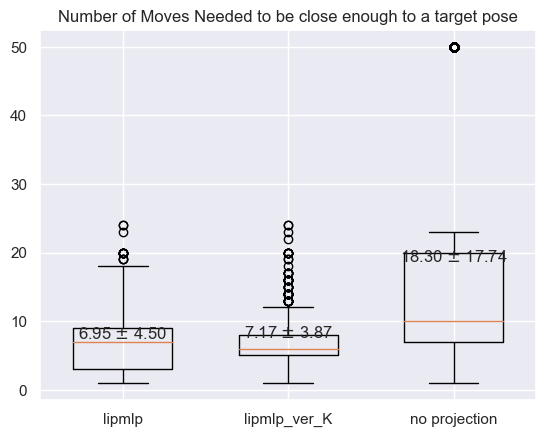

In [223]:
# plot the number of moves needed for eachw
i = 0
model_names = list(number_of_manipulations_dict.keys())
for model in model_names:
    number_of_manipulations_of_model = np.array(number_of_manipulations_dict[model])
    
    converges = np.where(number_of_manipulations_of_model < weights.shape[-1], True, False)
    converged_runs = number_of_manipulations_of_model[converges]
    if model == "no projection":
        converged_runs = number_of_manipulations_of_model
    
    # plot mean and std with a box plot, ignore the runs that didn't converge
    plt.boxplot(converged_runs, positions=[i], widths=0.6)
    # plot the scatter plot, only the 90% confidence interval
    # plt.scatter([i] * len(converged_runs), converged_runs, alpha=0.3)
    # label each box with a mean and std
    plt.text(i, np.mean(converged_runs), "{:.2f} $\pm$ {:.2f}".format
        (np.mean(converged_runs), np.std(converged_runs)), ha='center', va='bottom')
    
    # label the percentage of runs that converged to a reasonable accuracy
    print("A total of {} of the runs converged for model {}".format(len(converged_runs) / len(number_of_manipulations_of_model), model))

    i += 1
plt.title("Number of Moves Needed to be close enough to a target pose")
plt.xticks(range(len(model_names)), model_names)
plt.show()